.. _moments:

Note: This tutorial is available as a python notebook [here](https://github.com/mneeleman/qubefit/blob/master/doc/Tutorials/Moments.ipynb).

# Generating Moment Images

The goal of this tutorial is to show how you can use the ``qubefit`` package to make several diagnostic plots of the kinematics of your source. For this tutorial, we will be using the fully calibrated, continuum-subtracted data cube of the ionized carbon emission line from a z=4.26 galaxy discussed in [Neeleman et al. (2020)](https://arxiv.org/abs/2005.09661). In this paper, the emission is shown to arise from a smooth disk. The data cube used here has been slightly altered from the version used in the paper to reduce the size of the data file. 

To run this example, you will need to have access to the data. Currently the example file is part of the github code and lives in the `examples` folder, because it also is used to verify the code was installed correctly. This might change in future versions, in which case you will need to download the file and add it to the examples folder manually. The fits file `examples/WolfeDiskCube.fits` (6MB) is actually a sub-cube of the full continuum-subtracted data cube, which is signficantly larger (25MB).

## Image of the first 3 moments

The first image that we wish to make is a side-by-side image of the first three moments. These moments describe the velocity-integrated flux density (moment-zero), the velocity field (moment-one) and the velocity dispersion field (moment-2). In the next section, we will show an alternative way of generating the last two fields using a Gaussian fitting routine. This approach yields more robust velocity fields for these types of observations, and this is what was used in the paper.

To generate the plot, we will use the ``standardfig`` function, which is just a wrapper function for some ``matplotlib`` methods that are common among these figures. This function can be imported from the ``qfutils`` module. 

Generating the moment images is relatively straightforward, we simply call the ``calculate_moment`` method of the ``qube`` instance. For the moment-zero we wish to calculate the noise as well, which is best done for a large cube. We therefore make two moment images, one for the full data set and one for a trimmed region. The former will only be used to estimate the noise of the data.

Calling the ``calculate_moment`` method on the full data cube will use all of the data points in the cube. This is often not desirable for the moment-one and moment-two images. For these images, we wish to first mask out some of the noise. Here we will mask out all of the values below 1$\sigma$, we will then only show the moment-one and moment-two measurments for those pixels within the 3$\sigma$ contour of the moment-zero map, by applying a mask after we generated the moments.

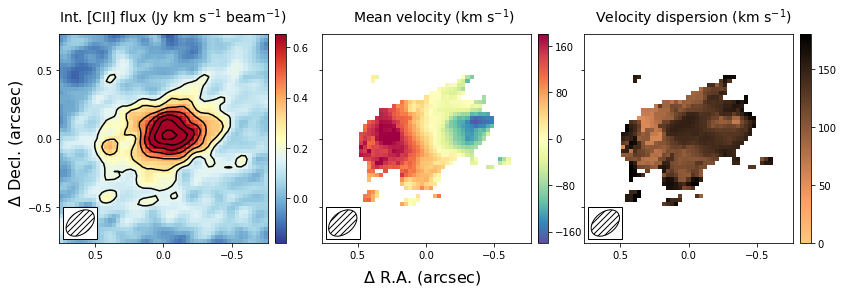

In [1]:
from qubefit.qube import Qube
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
from qubefit.qfutils import standardfig
import warnings
warnings.filterwarnings("ignore")


def make_image(Gaussian=False):
    # load the data, calculate RMS, and trim the size and make masked cube.
    Cube = Qube.from_fits('../../examples/WolfeDiskCube.fits')
    CubeSig = Cube.calculate_sigma()
    CubeS = Cube.get_slice(xindex=(100, 151), yindex=(103, 154))
    CubeSM = CubeS.mask_region(value=CubeSig)

    # calculate the noise in the moment-zero map for the 'full' data set.
    channels = (6, 19)  # channels that show emission
    tMom0 = Cube.calculate_moment(moment=0, channels=channels)
    Mom0Sig = tMom0.calculate_sigma()

    # calculate the moments (note the different qube instances used).
    Mom0 = CubeS.calculate_moment(moment=0, channels=channels)
    Mom1 = CubeSM.calculate_moment(moment=1, channels=channels)
    Mom2 = CubeSM.calculate_moment(moment=2, channels=channels)
    if Gaussian:
        Mom1, Mom2 = CubeS.gaussian_moment(mom1=Mom1, mom2=Mom2)

    # apply a mask to the moment-one and moment-two images
    Mom0Mask = Mom0.mask_region(value=3 * Mom0Sig, applymask=False)
    Mom1M = Mom1.mask_region(mask=Mom0Mask)
    Mom2M = Mom2.mask_region(mask=Mom0Mask)

    # set up the figure and axes.
    fig = plt.figure(1, (12., 4.))
    plt.subplots_adjust(left=0.08, right=0.95, top=0.95, bottom=0.08)
    grid = ImageGrid(fig, 111, nrows_ncols=(1, 3), axes_pad=0.5,
                     cbar_mode='each', cbar_location='right', cbar_pad=0.1)

    # plot the moments.
    scale = 0.03  # pixel scale (arcsec/pixel)
    origin = (25, 25)  # origin of the x and y ticks.
    clvl = np.arange(3, 20, 2) * Mom0Sig  # contour levels to draw
    standardfig(raster=Mom0, contour=Mom0, clevels=clvl, ax=grid[0],
                fig=fig, origin=origin, scale=scale, cmap='RdYlBu_r',
                cbar=True, cbaraxis=grid.cbar_axes[0], tickint=0.5,
                vrange=[-3 * Mom0Sig, 11 * Mom0Sig], vscale=0.2, flip=True)
    standardfig(raster=Mom1M, ax=grid[1], fig=fig, cmap='Spectral_r',
                origin=origin, scale=scale, tickint=0.5, cbar=True,
                cbaraxis=grid.cbar_axes[1], vrange=[-180, 180],
                vscale=80, flip=True)
    standardfig(raster=Mom2M, ax=grid[2], fig=fig, cmap='copper_r',
                origin=origin, scale=scale, tickint=0.5, cbar=True,
                cbaraxis=grid.cbar_axes[2], vrange=[0, 180],
                vscale=50, flip=True)

    # figure text
    fig.text(0.08, 0.92, 'Int. [CII] flux (Jy km s$^{-1}$ beam$^{-1}$)',
             fontsize=14, color='black')
    fig.text(0.42, 0.92, 'Mean velocity (km s$^{-1}$)',
             fontsize=14, color='black')
    fig.text(0.70, 0.92, 'Velocity dispersion (km s$^{-1}$)',
             fontsize=14, color='black')
    fig.text(0.5, 0.02, '$\\Delta$ R.A. (arcsec)', fontsize=16, ha='center')
    fig.text(0.02, 0.5, '$\\Delta$ Decl. (arcsec)', fontsize=16, va='center',
             rotation=90)
    plt.show()
    
make_image(Gaussian=False)

This figure shows nicely the extent of the emission and the clear velocity gradient in the central velocit field, which is consistent with the expected signature of a rotating disk. The right-most panel shows that the velocity dispersion is high, which is partly driven by the beam smearing of the data and partly driven by intrinsically high velocity dispersion.

## Comparing Gaussian Spectral Fitting and Moment images.

The above section describes how to make moment images to estimate the velocity field and velocity dispersion field. This method depends on removing some of the noise of the image to produce 'nice' images. If not done properly, this could bias results, especially in the regime of low signal-to-noise (S/N). Alternatively, one can fit a functional form to the spectrum of each spatial pixel and use this functional form to estimate the mean velocity and velocity dispersion. In most high redshift (low S/N) cases, a Gaussian is used as a function form. This method has as advantage that no data is thrown away, with the cost that an assumption is made of the intrinsic shape of the profile. 

In this section, we will create the same three panel figure as in the above section, but with the Gaussian image method. As you can see it simply adds a single line to the code above, which uses the moment-one and moment-two images as initial guesses to the Gaussian fitting method. The code will take a bit longe to run as it needs to fit a Gaussian to each spatial pixel in the data cube.

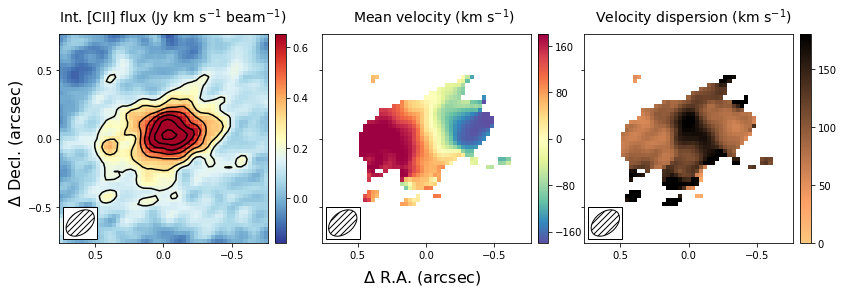

In [2]:
make_image(Gaussian=True)

The result is globally similar to the first image, but with some slight differences. The most important difference is that the velocity gradient is stronger in the central panel, and the velocity dispersion is smaller. This likely is due to some of the noise being interpreted as an increase in the velocity dispersion in the moment method, which due to beam smearing lowered the velocity gradient as well. Part of this could have been remedied using a different threshold in the masking during the moment image, but this is not needed in the Gaussian fitting approach. For low resolution imaging, where the spectral profiles are roughly Gaussian, this approach is therefore more robust.

## Position - Velocity Diagram

Another important diagnostic figure to make is a position-velocity (p-v) diagram. The p-v diagrams are the velocity profiles along a certain line drawn through the data cube, similar to the 2D information obtained with a spectrograph using a slit. The qube class has a rather rudementary implementation of a position-velocity diagram built in. There are much more advanced packages out there (e.g., [pvextractor](https://pvextractor.readthedocs.io/en/latest/)), but this implementation will give you a good first glance.

The pv data can be loaded using a simple call of the method ``pvdiagram``. The output is a dictionary with some useful plotting information in it, which can be used in conjuction with matplotlib.pyplot to make the pv-dagram image.

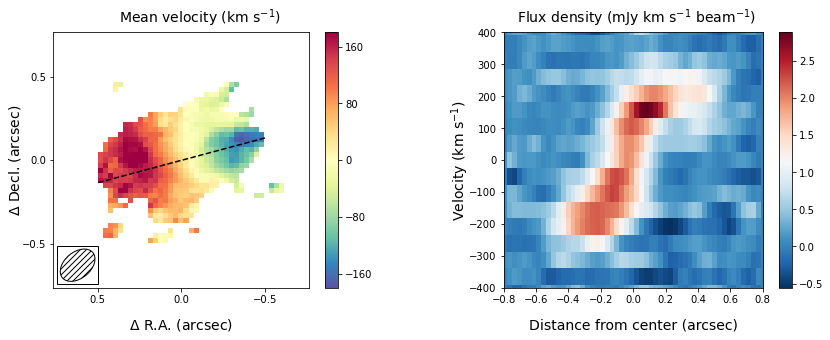

In [3]:
# load the data, calculate RMS, and trim the size and make mask cube
Cube = Qube.from_fits('../../examples/WolfeDiskCube.fits')
CubeSig = Cube.calculate_sigma()
CubeS = Cube.get_slice(xindex=(100, 151), yindex=(103, 154))
CubeSM = CubeS.mask_region(value=CubeSig)

# make the moment-one image
channels = (6, 19)  # channels that show emission
tMom0 = Cube.calculate_moment(moment=0, channels=channels)
Mom0Sig = tMom0.calculate_sigma()
Mom0 = CubeS.calculate_moment(moment=0, channels=channels)
Mom0Mask = Mom0.mask_region(value=3 * Mom0Sig, applymask=False)
Mom1 = CubeSM.calculate_moment(moment=1, channels=channels)
Mom1M = Mom1.mask_region(mask=Mom0Mask)

# set up the figure and axes.
fig, axs = plt.subplots(1, 2, figsize=(12, 4.5))
fig.subplots_adjust(left=0.07, bottom=0.15, right=0.97, top=0.94,
                    wspace=0.40, hspace=None)

# plot the moment-one
center = (25, 25)  # origin of the x and y ticks.
scale = 0.03  # pixel scale (arcsec/pixel)
PA = 105  # the angle of the pv-line (PA of major axis)
standardfig(raster=Mom1M, ax=axs[0], fig=fig, cmap='Spectral_r',
            origin=center, scale=scale, tickint=0.5, cbar=True,
            cbaraxis=None, vrange=[-180, 180], vscale=80, flip=True)

# the pv line to draw
x = np.array([-0.5, 0.5])
y = -1 * (np.tan((PA + 90) * np.pi / 180) * x)
# the -1 is needed because the axes are flipped.
axs[0].plot(x, y, ls='--', color='black')
axs[0].text(0.5, -0.16, '$\\Delta$ R.A. (arcsec)', fontsize=14,
            color='black', transform=axs[0].transAxes, ha='center')
axs[0].text(-0.18, 0.5, '$\\Delta$ Decl. (arcsec)', fontsize=14,
            color='black', transform=axs[0].transAxes, va='center', rotation=90)

# get the pv-diagram
PV = CubeS.pvdiagram(PA, center, width=5, scale=0.03)
im = axs[1].imshow(PV['pvdata'] * 1E3, aspect='auto', origin='lower',
                   cmap='RdBu_r', extent=PV['extent'], alpha=1.0)
cbr = plt.colorbar(im, ax=axs[1])
axs[1].set_xlim(-0.8, 0.8)
axs[1].set_ylim(-400, 400)
axs[1].text(0.5, -0.16, 'Distance from center (arcsec)', fontsize=14,
            color='black', transform=axs[1].transAxes, ha='center')
axs[1].text(-0.21, 0.5, 'Velocity (km s$^{-1}$)', fontsize=14,
            color='black', transform=axs[1].transAxes, va='center',
            rotation=90)

# additional text
fig.text(0.15, 0.97, 'Mean velocity (km s$^{-1}$)', fontsize=14,
         color='black')
fig.text(0.61, 0.97, 'Flux density (mJy km s$^{-1}$ beam$^{-1}$)',
         fontsize=14, color='black')
plt.show()

The panel on the right shows the pv-diagram along the dashed line in the left panel, which is the measured major axis of the galaxy. The typical S-shape curve is a signature of a disk galaxy. Other pv-diagrams can also be drawn such as along the minor axis of the galaxy by simply changing the angle in the method call.